In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt  
from copy import deepcopy
from preprocessing import Preprocess
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import sqrt

In [2]:
#Rule Object structure
class rule_object():
    def __init__(self,complete_rules,prem_terms,rules,wd_,index):
        self.complete_rules = complete_rules
        self.prem_terms = prem_terms
        self.rules = rules
        self.index = index
        self.wd_ = wd_

In [3]:
#Basic informations 

num_predictors = 15
num_input = 15
lag = 30
lag_notused = np.array([[4,5],[4,5],[4],[4,5]])
not_used_lag = False



#Actually, lag stands for all inputs for each serie. Example, lag = 2 uses s(t) and s(t-1) to predict s(t+1)
diff_series = False
detrend_series = False

C:\Users\Diego\AppData\Local\Temp\ipykernel_17420\2749710493.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lag_notused = np.array([[4,5],[4,5],[4],[4,5]])


In [4]:
dataset = pd.read_csv('exchange_rate.txt',header=None)

In [5]:
dataset.head()

,0,1,2,3,4,5,6,7
0,0.7855,1.6110,0.861698,0.634196,0.211242,0.006838,0.5930,0.525486
1,0.7818,1.6100,0.861104,0.633513,0.211242,0.006863,0.5940,0.523972
2,0.7867,1.6293,0.861030,0.648508,0.211242,0.006975,0.5973,0.526316
3,0.7860,1.6370,0.862069,0.650618,0.211242,0.006953,0.5970,0.523834
4,0.7849,1.6530,0.861995,0.656254,0.211242,0.006940,0.5985,0.527426


In [6]:
dataset.corr()

,0,1,2,3,4,5,6,7
0,1.000000,0.211263,0.913903,0.811949,0.422523,0.661676,0.900563,0.819556
1,0.211263,1.000000,0.346885,-0.054231,0.041920,-0.199195,0.201379,-0.172660
2,0.913903,0.346885,1.000000,0.709560,0.508899,0.552243,0.776043,0.656708
3,0.811949,-0.054231,0.709560,1.000000,0.344609,0.633852,0.878720,0.907193
4,0.422523,0.041920,0.508899,0.344609,1.000000,-0.030113,0.255796,0.237887
5,0.661676,-0.199195,0.552243,0.633852,-0.030113,1.000000,0.555616,0.708835
6,0.900563,0.201379,0.776043,0.878720,0.255796,0.555616,1.000000,0.851381
7,0.819556,-0.172660,0.656708,0.907193,0.237887,0.708835,0.851381,1.000000


In [7]:
MA = 5
MA_values = np.zeros((dataset.shape[0]-MA,dataset.shape[1]))
for i in range(dataset.shape[1]):
    a = dataset[i].rolling(window=MA).mean().values
    MA_values[:,i] = a[5:]

In [8]:
MA_dataset = pd.DataFrame(MA_values)

In [9]:
#We are going to split between training, validation and test set.
#Training set: 2 months of data (168*60) + lag
#Validation set: 168 steps (1 week)
#Test set: 168 steps (1 week)

h_test = int(0.2*dataset.shape[0])
h_val = 24
#h_train = dataset.shape[0] - h_val - h_test - lag - 2
h_train = 24*30

a = MA_dataset.shape[0]
all_data = MA_dataset[a - h_train - lag - 1 - h_val - h_test:]
training_data = MA_dataset[a - h_train - lag - 1 - h_val - h_test:a-h_test]
test_data = MA_dataset[a - h_test:a]

In [10]:
h_train

720

In [11]:
training_values = training_data.values

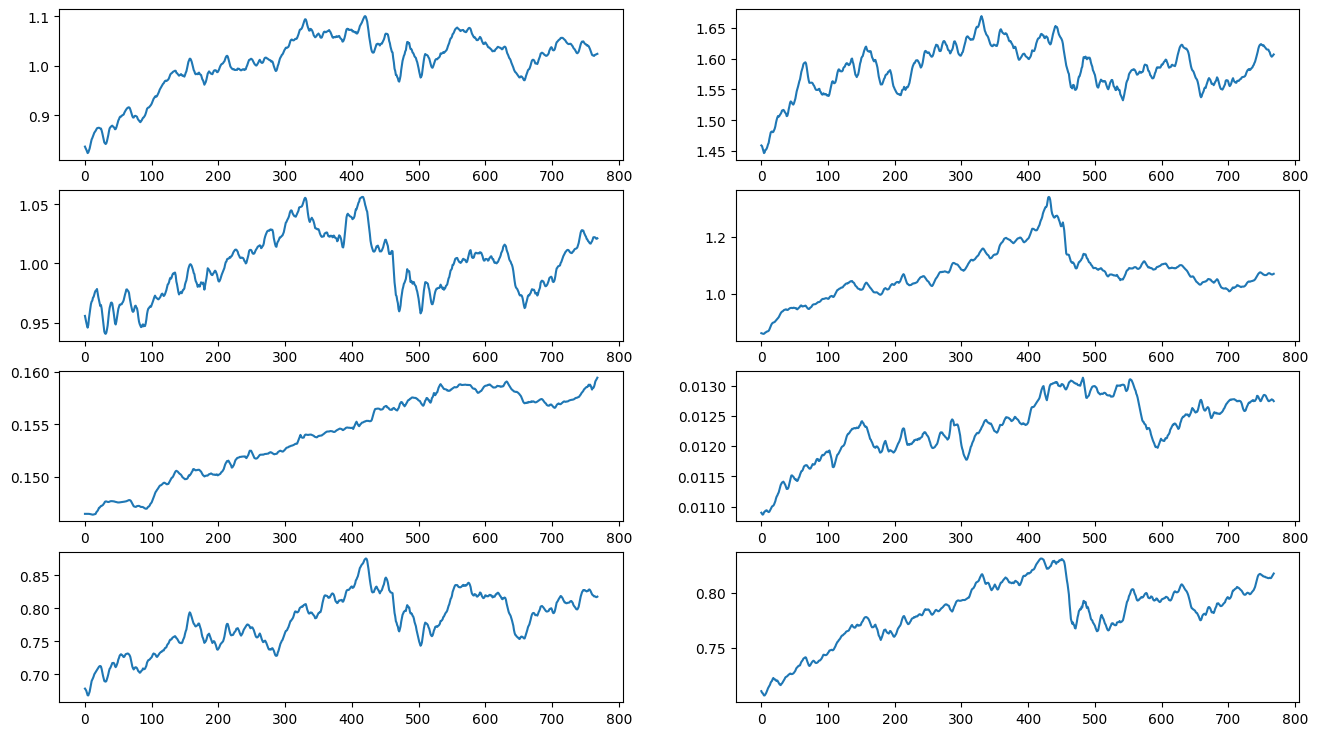

In [12]:
plt.figure(figsize=(16,9))
for n in range(8):
    plt.subplot(4,2,n+1)
    plt.plot(training_values[:,n])

In [13]:
#data = data1[:,[0, 61, 147, 241]]
#data_ = training_values[:,[0,6]]
#data_ = training_values[:,[0,2,6,7]]
data_ = training_values
#data_ = training_values[:,[0, 61, 147, 241]]

In [14]:
data_.shape

(769, 8)

In [15]:
#bin_values = 12; #Representação da binarização do tempo.
num_series = data_.shape[1]  #Numero de series do problema, extraído dos dados

max_rulesize = 5 #Max numbers of premises rules.
min_activation = 0.2 #Minimum activation

form_method = 'mean'
split_method = 'voting'
solve_method = 'mqr'
#####Definicao de funcoes######
#detrend_method = ''
#bin_method = ''

fuzzy_method = 'mfdef_triangle'
num_groups = 7

defuzz_method = 'cog'

ensemble_rules = None

total_number = data_.shape[1]*lag


filepath = 'results V1'



In [16]:
#Normalize data 
scaler = StandardScaler()
#scaler = MinMaxScaler()
preprocess_data = Preprocess(data_,h_prev=h_val,num_series=num_series, lag=lag)

#For training set
#training_set_orig, val_set_orig = preprocess_data.diff_series()
#training_set_orig, val_set_orig = preprocess_data.split_data()
training_set_orig, val_set_orig, trends = preprocess_data.detrend_series()

diff_data = np.concatenate((training_set_orig, val_set_orig))

norm_data = scaler.fit_transform(diff_data)
training_set = scaler.transform(training_set_orig)
val_set = scaler.transform(val_set_orig)

training_set[abs(training_set) > 3] = 0

yt, yp, yp_lagged = preprocess_data.delay_input(in_sample = training_set, lag = lag)
#For all set. This will be useful for initial values of prediction
all_yt, all_yp, all_lagged = preprocess_data.delay_input(in_sample = norm_data, lag = lag)

In [17]:
process_all = Preprocess(all_data.values, h_prev = h_test, num_series=num_series, lag=lag)
train_val_org, test_set_orig, a_trends = process_all.detrend_series()
detrend_data = np.concatenate((train_val_org, test_set_orig))

norm_data = scaler.fit_transform(detrend_data)
training_set = scaler.transform(train_val_org)
#val_set = scaler.transform(val_set_orig)

test_set_norm = scaler.transform(test_set_orig)
#all_data_norm = scaler.transform(all_data)

test_all_yt, test_all_yp, test_all_lagged = preprocess_data.delay_input(in_sample = norm_data, lag = lag)

In [18]:
test_all_lagged.shape

(2261, 192)

In [19]:
#diff_data.shape
#diff_data = data_

In [20]:
#plt.plot(yt[:,2])
#plt.ylabel('Diff values')
#plt.xlabel('Timestamp (h)')

In [21]:
#plt.plot(norm_data[:,2])
#plt.ylabel('Diff values')
#plt.xlabel('Timestamp (h)')

In [22]:
#For all set. This will be useful for initial values of prediction
#all_yt, all_yp, all_lagged = preprocess_data.delay_input(in_sample = diff_data, lag = lag)

In [23]:
#plt.plot(yt[200:,1])

In [24]:
#assert val_set.shape[0] == h_val
#assert yp_lagged.shape[0] == h_train
#assert yt.shape[0] == h_train

In [25]:
#dataset.shape

In [19]:
import seaborn as sns
from copy import deepcopy
from utils import *

import itertools
import json
import os

#For e-autoMFIS, we import all of them.
from autoMFIS_test import autoMFIS
import numpy as np
import scipy.io
from reweight import Reweight
from fuzzyfication import Fuzzification
from defuzzification import Defuzzification
import matplotlib.pyplot as plt
from predict import predict, predict_pattern



def convert_object_to_float(data,datanames):
    
    for name in datanames:
        dname = data[name].values.astype('str')
        dname = [new_value.replace(',','.') for new_value in dname]
        data[name] = dname
        data[name] = data[name].astype(float)
    return data

##Assertion for ensemble rules
#Somehow, when appending rules, ensemble_rules[:,1] has a erroneous form. This part seems to normalize it.

#This module correct this error. Also, we are going to use some assertion to check if rules contains the same antecedents.
def correct_bug(ensemble_rules,max_rulesize=0):
    correct_rule = []
    d_stacked_rules = []
    new_ensemble_rules = np.zeros(shape=ensemble_rules.shape, dtype=object)


    for  n_times in range(ensemble_rules.shape[1]):
        t_rules = ensemble_rules[:,n_times]
        correct_rule = []
        d_stacked_rules = []
        k = 0
        for rule in t_rules:
            #print(rule)
            #print(len(rule))
            #Check if there's a rule bigger than max_rulesize + 1 (#antecedents + #consequent)
            if len(rule) > max_rulesize + 1:
                #print(rule)
                for i in rule:
                    #k += 1
                    if isinstance(i,tuple):
                        #print(i)
                        correct_rule.append(i)
                    else:
                        if len(correct_rule) == 0:
                            #print(i)
                            pass
                            #d_stacked_rules.append(i)
                        else:
                            #print(correct_rule)
                            new_ensemble_rules[k,n_times] = correct_rule
                            k += 1
                            #d_stacked_rules.append(correct_rule)
                            correct_rule = []
                            #d_stacked_rules.append(i)
            else:
                new_ensemble_rules[k,n_times] = rule
                k += 1
                #d_stacked_rules.append(rule)
            
        #new_ensemble_rules[:,i] = np.array(d_stacked_rules)

    return new_ensemble_rules

def remove_duplicates(new_ensemble_rules,ensemble_prem_terms, ensemble_antecedents):
    t_rules = deepcopy(new_ensemble_rules[:,0])
    no_duplicated_ensemble = np.zeros(new_ensemble_rules.shape,dtype=object)
    no_duplicated_prem_terms = np.zeros(ensemble_prem_terms.shape)
    no_duplicated_antecedents = np.zeros(ensemble_antecedents.shape,dtype=object)
    new_t_rules = None

    k = 0
    j = 0
    for rule in t_rules:
        if new_t_rules is None:
            new_t_rules = [rule]
            no_duplicated_ensemble[k,:] = deepcopy(new_ensemble_rules[j,:])
            no_duplicated_prem_terms[k,:] = deepcopy(ensemble_prem_terms[j,:])
            no_duplicated_antecedents[k,:] = deepcopy(ensemble_antecedents[j,:])
            k += 1

        elif not check_duplicate_rules(rule,new_t_rules):
            new_t_rules.append(rule)
            no_duplicated_ensemble[k,:] = deepcopy(new_ensemble_rules[j,:])
            no_duplicated_prem_terms[k,:] = deepcopy(ensemble_prem_terms[j,:])
            no_duplicated_antecedents[k,:] = deepcopy(ensemble_antecedents[j,:])
            k += 1
        j += 1

    new_rules = deepcopy(no_duplicated_ensemble[:k,:])
    new_prem_terms = deepcopy(no_duplicated_prem_terms[:k,:])
    new_antecedents = deepcopy(no_duplicated_antecedents[:k,:])

    return new_rules, new_prem_terms, new_antecedents



In [27]:
#t = [a + n for n in range(0,data.shape[0]-168,168) for a in range(24)]
#t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]
#yp = deepcopy(yp[t_lagged,:])
#yt = deepcopy(yt[t_lagged,:])
#yp_lagged = deepcopy(yp_lagged[t_lagged,:])

#data = deepcopy(data[t[len(t)-len(t_lagged):],:])
#in_sample = data[:data.shape[0]-h_prev,:]
#out_sample = data[data.shape[0]-h_prev:,:]

#print(len(t_lagged))

In [20]:
###############Fuzzificacao

Fuzzyfy = Fuzzification(fuzzy_method)

#Lembrete: 
#axis 0 - Registros da série
#axis 1 - Valor de pertinência ao conjunto Fuzzy
#axis 2 - Numero de séries

first_time = True
for n in range(num_series):
    
    _, mf_params = Fuzzyfy.fuzzify(training_set[:,n],np.array([]),num_groups=num_groups)
    mX, _ = Fuzzyfy.fuzzify(yp[:,n],mf_params,num_groups=num_groups)
    mY, _ = Fuzzyfy.fuzzify(yt[:,n],mf_params,num_groups=num_groups)
    if first_time:
        mX_ = np.ndarray([mX.shape[0],mX.shape[1], num_series])
        mY_ = np.ndarray([mY.shape[0],mY.shape[1], num_series])
        mf_params_ = np.ndarray([mf_params.shape[0],num_series])
        first_time = False
    mX_[:,:,n] = mX
    mY_[:,:,n] = mY
    mf_params_[:,n] = mf_params.ravel()
    #print(mf_params)
    #print(mX.shape)


mX_lagged_ = np.ndarray([mX_.shape[0],mX_.shape[1],yp_lagged.shape[1]])
for i in range(num_series):
    mf_params = mf_params_[:,i]
    for j in range(lag):
        mX, _ = Fuzzyfy.fuzzify(yp_lagged[:,i*lag+j],mf_params,num_groups=num_groups)
        mX_lagged_[:,:,i*lag+j] = mX
        #print(i*lag+j)


#mX_lagged_[:,:,not_select_subsample] = 0

#print(mX_lagged_[:,:,not_select_subsample])
############## Formulacao
if not_used_lag:
    new_mX, lags_used = remove_lags(mX_lagged_,lag_notused,num_series,lag)
else:
    new_mX = mX_lagged_



In [21]:

min_error = 300.0

bres = min_error

initial_values = all_lagged[yp_lagged.shape[0],:].reshape(1,-1)
in_sample = deepcopy(training_set)
out_sample = deepcopy(val_set)




print('='*89)

print(f'Shape of in-sample is {in_sample.shape[0]}')
#assert in_sample.shape[0] == h_train//7
print(f'Shape of lagged data is {yp_lagged.shape[0]}')
#assert yp_lagged1.shape[0] == h_train//manual_pattern
print(f'Shape of validation set is {out_sample.shape[0]}')

print('='*89)



#Concatenate rules
for i in range(num_predictors):
    try:
        model = autoMFIS(diff_series=diff_series,detrend_series=detrend_series,fuzzy_method=fuzzy_method,solve_method=solve_method,defuzz_method=defuzz_method, num_groups = num_groups, h_prev = out_sample.shape[0], num_series = num_series, max_rulesize = max_rulesize, min_activation = min_activation, lag = lag, hide_values = False, form_method = form_method, split_method = split_method, show=False)

        
        not_select_subsample = np.random.choice(total_number,total_number-num_input,replace=False)
        t_mX_lagged = deepcopy(mX_lagged_)
        t_mX_lagged[:,:,not_select_subsample] = 0

        model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, t_mX_lagged)        

        complete_rules, prem_terms, rules, agg_training, wd_ = model.train(norm_data, yt=yt,yp=yp,yp_lagged=yp_lagged,in_sample=in_sample,out_sample=out_sample,not_select_subsample=not_select_subsample, lag_notused=[],debug=True)



        #complete_rules, prem_terms, rules, agg_training, wd_ = autoMFIS(data_,lag=lag, lag_notused=lag_notused, not_used_lag=not_used_lag,not_select_subsample=not_select_subsample, h_prev = out_sample.shape[0], diff_series=diff_series, detrend_series=detrend_series, num_series=num_series, max_rulesize=max_rulesize, min_activation=min_activation, fuzzy_method=fuzzy_method, num_groups=num_groups,solve_method='mqr',defuzz_method=defuzz_method,yt=yt1,yp=yp1,yp_lagged=yp_lagged1,in_sample=in_sample,out_sample=out_sample)
        print(f'Predict on validation set - #{i}')
        #Prediction of a single subset
        #yt_totest, errors = model.predict(initial_values, data=norm_data, in_sample = yt, out_sample=val_set, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'p_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=min_error, fig_axis=[4,2],ndata=MA_dataset,show=False)
        predicted_values = np.zeros(test_data.values.shape)
        init = in_sample.shape[0]
        for k in range(0,h_test,24):

            initial_values = test_all_lagged[yp_lagged.shape[0]+k,:].reshape(1,-1)
            yt_totest, _ = model.predict(initial_values, data=norm_data, in_sample = yt, out_sample=val_set, agg_training=agg_training,h_prev=24,n_attempt=f'p_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=min_error, fig_axis=[4,2],ndata=MA_dataset,show=False)
            a = scaler.inverse_transform(yt_totest)
            #print(k)
            if (k+24 > predicted_values.shape[0]):
                bb = predicted_values.shape[0] - k
                b = a[-bb:,:] + a_trends[init+k:init+k+bb,:]
                predicted_values[k:k+bb,:] = b
            else:
                b = a + a_trends[init+k:init+k+24,:]
                predicted_values[k:k+24,:] = b
        F = predicted_values
        A = test_data.values     
        num = sqrt(np.sum((F-A)**2))
        den = sqrt(np.sum((A-np.mean(A))**2))
        rrse = num/(den+0.0000001)
        print(rrse)
        #errors = predict(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data_,in_sample=in_sample,out_sample=out_sample, lag = lag, mf_params_=mf_params_,num_series=num_series,agg_training=agg_training,yp_lagged=yp_lagged1,h_prev=out_sample.shape[0],not_used_lag=not_used_lag,n_attempt=f'p_{n_pattern}_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules,filepath=filepath,lim=3.0,defuzz_method=defuzz_method,fig_axis=[2,2])
        #print(errors)
        #print(complete_rules)

        if rrse < bres:
            bres = rrse 
            y_best = yt_totest 
            best_complete_rules = complete_rules 
            best_prem_terms =  prem_terms
            best_rules = rules
            best_agg_training = agg_training 
            best_wd_ = wd_ 
            best_t_mx_lagged = t_mX_lagged

        
        if rrse < 0.09:
            if ensemble_rules is None:
                ensemble_rules = complete_rules
                ensemble_prem_terms = prem_terms
                ensemble_antecedents = rules
                #print(ensemble_rules.shape)
            else:
                ensemble_rules = np.concatenate((ensemble_rules, complete_rules))
                
                ensemble_prem_terms = np.concatenate((ensemble_prem_terms,prem_terms))
                ensemble_antecedents = np.concatenate((ensemble_antecedents,rules))
                #print(ensemble_rules.shape)
                #print(ensemble_prem_terms.shape)
            #print(ensemble_rules[:,0])
        elif ensemble_rules is None and i == num_predictors - 1:
            ensemble_rules = complete_rules
            ensemble_prem_terms = prem_terms
            ensemble_antecedents = rules
            print('No rules match criteria. Using rules to fill the gap')
        #print('RMSE Errors = {}'.format(errors[0,:]))
        # print('RRSE Errors = {}'.format(errors[1,:]))
        #print('Mean RRSE Error = {}'.format(np.mean(errors[1,:])))
        
        '''
        print('RRSE Errors = {}'.format(errors[1,:]))
        if errors[1,0] < min_error:
            ensemble_rules = deepcopy(complete_rules)
            ensemble_prem_terms = deepcopy(prem_terms)
            ensemble_antecedents = deepcopy(rules)
            wd__ = wd_
            min_error = errors[1,0]
        '''
    
    except Exception as e:
        print(e)
        pass
    

Shape of in-sample is 769
Shape of lagged data is 720
Shape of validation set is 24
Step 1 - Fuzzification
Step 2 - Formulation
Step 3 - Split
Step 4 - Reweight
Step 5 - Defuzzification
Predict on validation set - #0
0.10158555238794773
Step 1 - Fuzzification
Step 2 - Formulation
Step 3 - Split
Step 4 - Reweight
Step 5 - Defuzzification
Predict on validation set - #1
0.11591756674974217
Step 1 - Fuzzification
Step 2 - Formulation
Step 3 - Split
Step 4 - Reweight
Step 5 - Defuzzification
Predict on validation set - #2
0.13687109231562822
Step 1 - Fuzzification
Step 2 - Formulation
Step 3 - Split
Step 4 - Reweight
Step 5 - Defuzzification
Predict on validation set - #3
0.11334967722695814
Step 1 - Fuzzification
Step 2 - Formulation
Step 3 - Split
Step 4 - Reweight
Step 5 - Defuzzification
Predict on validation set - #4
0.1275951569046267
Step 1 - Fuzzification
Step 2 - Formulation
Step 3 - Split
Step 4 - Reweight
Step 5 - Defuzzification
Predict on validation set - #5
0.14093104819377625

In [ ]:
rrse

In [ ]:
bb

In [ ]:
predicted_values = np.zeros(test_data.values.shape)
init = in_sample.shape[0]
for k in range(0,h_test,24):
    print(k)
    initial_values = test_all_lagged[yp_lagged.shape[0]+k,:].reshape(1,-1)
    yt_totest, _ = model.predict(initial_values, data=norm_data, in_sample = yt, out_sample=val_set, agg_training=agg_training,h_prev=24,n_attempt=f'p_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=min_error, fig_axis=[4,2],ndata=MA_dataset,show=False)
    a = scaler.inverse_transform(yt_totest)
    b = a + a_trends[init+k:init+k+24,:]
    predicted_values[k:k+24,:] = b

In [ ]:
from math import sqrt

F = predicted_values[:1510,:]
A = test_data.values[:1510,:]     
num = sqrt(np.sum((F-A)**2))
den = sqrt(np.sum((A-np.mean(A))**2))
rrse = num/(den+0.0000001)

In [ ]:
num = sqrt(np.sum((F-A)**2))
den = sqrt(np.sum((A-np.mean(A))**2))
rrse = num/(den+0.0000001)

In [ ]:
rrse 

In [ ]:
for i in range(F.shape[1]):
    plt.figure()
    plt.plot(F[:,i])
    plt.plot(A[:,i])

In [ ]:
for i in range(data_.shape[1]):
    plt.figure()
    plt.plot(b[:,i])
    plt.plot(data_[-24:,i])
    plt.legend(['Predicted','Actual'])

In [ ]:
in_sample.shape

In [ ]:
complete_rules[:,1]

In [ ]:
k = 0
i = 0

prems_activated = np.where(prem_terms[k,:] > min_activation)[0]
mask_mY = mY_[prems_activated,:,i]
max_index = np.argmax(mY_[prems_activated,:,i],axis=1)
index, count_index = np.unique(max_index, return_counts = True)
#print(count_index)
max_id = index[np.argmax(count_index)]

In [ ]:
mask_mY[:,2][np.where(max_index == 2)[0]].mean()

In [ ]:
max_index[max_index==1].shape

In [ ]:
a,b = np.unique(max_index, return_counts=True)

In [ ]:
blah = np.array([0, 0, 1, 1])
a, b = np.unique(blah, return_counts=True)
np.argmax(b)

In [ ]:
from utils import nmean_activation, check_if_inside, check_duplicate_rules, rearranje_rules, freq_activation, mean_activation
from tnorm import tnorm_product

In [ ]:
count_tnorm = np.vstack((mX_lagged_[:,2,16],mX_lagged_[:,0,16]))
tnorm_ = tnorm_product(count_tnorm)
a,b,c = mean_activation(tnorm_,0.5)
print(a)
print(b)
print(c)

In [ ]:
complete_rules[:,0].shape

In [ ]:
np.unique(mX_lagged_)

In [ ]:
a,b,c = nmean_activation(mX_lagged_[:,3,70],0.5)
print(a)
print(b)
print(c)

In [ ]:
complete_rules

In [ ]:
'''
init = 0
for i,a in enumerate(list_rules):
    try:
        ensemble_rules = a.complete_rules
        ensemble_prem_terms = a.prem_terms
        ensemble_antecedents = a.rules
        
        new_ensemble_rules = correct_bug(ensemble_rules,max_rulesize=max_rulesize)

        new_rules, new_prem_terms, new_antecedents = remove_duplicates(new_ensemble_rules,ensemble_prem_terms,            ensemble_antecedents)

        wd_, _ = model.reweight_mf(mY_[init:init+ensemble_prem_terms.shape[1],:,:], new_rules, new_prem_terms)
        
        list_rules[i].complete_rules = new_rules
        list_rules[i].prem_terms = new_prem_terms
        list_rules[i].rules = new_antecedents
        list_rules[i].wd_ = wd_

        init += ensemble_prem_terms.shape[1]

    except Exception as e:
        print(e)
'''

In [ ]:
initial_values = all_lagged[yp_lagged.shape[0]-1,:].reshape(1,-1)

test_values = test_data.values



In [ ]:
errors1

In [ ]:
#errors = predict_pattern(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data_, lag = lag, mf_params_=mf_params_,num_series=num_series,h_prev=h_test,not_used_lag=not_used_lag,n_attempt=f'_predict_',wd_=wd_,filepath=filepath,lim=3.0,defuzz_method=defuzz_method,fig_axis=[2,2], n_patterns=n_pattern, list_rules = list_rules)



In [ ]:
errors1

In [ ]:
#new_ensemble_rules = correct_bug(ensemble_rules,max_rulesize=max_rulesize)

#new_rules, new_prem_terms, new_antecedents = remove_duplicates(new_ensemble_rules,ensemble_prem_terms, ensemble_antecedents)

#rw = Reweight(mY_,new_rules,new_prem_terms)
#wd_, agg_training = rw.run('mqr',debug=False)

#predict(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data,in_sample=in_sample,out_sample=out_sample, lag = lag, mf_params_=mf_params_,num_series=num_series,agg_training=agg_training,yp_lagged=yp_lagged,h_prev=h_prev,not_used_lag=not_used_lag,n_attempt='_{}'.format(i),wd_=wd_,ensemble_antecedents=new_antecedents,ensemble_rules=new_rules,filepath=filepath,lim=3.0,defuzz_method=defuzz_method,fig_axis=[2,2])

In [ ]:
#rw = Reweight(mY_,complete_rules,prem_terms)
#wd_, agg_training = rw.run('mqr',debug=False)
#defuzz = Defuzzification(mf_params_,num_series)
#y_predict_ = defuzz.run('mom',agg_training,show=True)

In [ ]:
k = 2
t = [a + n for n in range(0,data.shape[0]-168,168) for a in range(24*k,24*(k+1))]
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]
yp1 = deepcopy(yp[t_lagged,:])
yt1 = deepcopy(yt[t_lagged,:])
yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

data1 = deepcopy(data[t[len(t)-len(t_lagged):],:])
in_sample = data1[:data1.shape[0]-h_prev,:]
out_sample = data1[data1.shape[0]-h_prev:,:]

print(len(t_lagged))


In [ ]:
ll = [rule_object(None,None,None,k) for k in range(7)]

In [ ]:
wd_.shape

In [ ]:
complete_rules.shape

In [ ]:
list_rules[1].complete_rules

In [ ]:
all_lagged.shape

In [ ]:
all_yt[yp_lagged.shape[0] + t_val[0],:]

In [ ]:
out_sample[0,:]

In [ ]:
test_set = test_data.values

In [ ]:
plt.plot(np.arange(0,training_set.shape[0]),training_set[:,0],label='Train')
plt.plot(np.arange(training_set.shape[0],training_set.shape[0]+val_set.shape[0]),val_set[:,0],color='r',label='Validation')
plt.plot(np.arange(training_set.shape[0]+val_set.shape[0], training_set.shape[0]+val_set.shape[0] + test_set.shape[0]),test_set[:,0],label='Test')
plt.xlabel('Time')
plt.ylabel('Traffic rate')
plt.title('Data split')
plt.legend(['Train','Validation','Test'])

In [ ]:
a = dataset.corr()

In [ ]:
np.sort(a[0].values)[-5:]

In [ ]:
b = a[0].values

In [ ]:
for i in np.sort(a[0].values)[-5:]:
    print(np.where(np.isclose(b,i)))

In [ ]:
type(b)